In [1]:
# Shaimae Elhajjajy
# February 6, 2024
# Run ArchR on the 10X Multiome PBMC scATAC 10K data, but use tiles as anchors for calculating scATAC fragment counts.
# Note! Run with singularity image archr_seuratv5.sif

In [1]:
# Libraries
library(ArchR)
library(BSgenome)
library(data.table)
library(GenomicRanges)


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--' ,----`-,__ ___/'  --,-`-===================##========>
       \               '        ##_______ _____ ,--,__,=##,__   ///
        ,    __==    ___,-,__,--'#'  ==='      `-'    | ##,-/
        -,____,---'       \\####\\________________,--\\_##,/
           ___      .______        ______  __    __  .______      
          /   \     |   _ 

In [2]:
# Parameters
set.seed(99)
addArchRThreads(threads = 16)

Setting default number of Parallel threads to 16.



In [3]:
# Load in custom genome
library(BSgenome.GRCh38.ENCODE, lib.loc = "/data/zusers/elhajjajys/genomes/BSgenome/GRCh38")

In [4]:
# Set location of GENCODE annotation
GENOMES_DIR = "/data/zusers/elhajjajys/genomes"
GTF_BASE = "gencode.v40.basic.annotation"

In [5]:
# Read in blacklisted regions (i.e., exclusion set)
# Note: this is the official ENCODE blacklist for hg38, and is also built-in to Signac.
blacklist_df = fread(paste0(GENOMES_DIR, "/GRCh38.ENCODE.blacklist.ENCFF356LFX.bed"), sep = "\t")
colnames(blacklist_df) = c("chr", "start", "end")
blacklist_gr = makeGRangesFromDataFrame(blacklist_df, keep.extra.columns = TRUE)

In [6]:
# Create genome annotation (to infer chromosome sizes)
genomeAnnotation <- createGenomeAnnotation(genome = BSgenome.GRCh38.ENCODE, blacklist = blacklist_gr)

Getting genome..

Attempting to infer chromSizes..

Using provided blacklist...



In [7]:
# Create general gene reference (all genes)
genes_df = fread(paste0(GENOMES_DIR, "/", GTF_BASE, "/", GTF_BASE, ".gene.bed"), sep = "\t")
colnames(genes_df) = c("chr", "start", "end", "filler1", "filler2", "strand", "symbol", "gene_name", "gene_type", 
                       "transcript_id", "transcript_name", "transcript_type")
genes_gr = makeGRangesFromDataFrame(genes_df, keep.extra.columns = TRUE)

exons_df = fread(paste0(GENOMES_DIR, "/", GTF_BASE, "/", GTF_BASE, ".exon.bed"), sep = "\t")
colnames(exons_df) = c("chr", "start", "end", "filler1", "filler2", "strand", "symbol", "gene_name", "gene_type", 
                       "transcript_id", "transcript_name", "transcript_type")
exons_gr = makeGRangesFromDataFrame(exons_df, keep.extra.columns = TRUE)

tss_df = fread(paste0(GENOMES_DIR, "/", GTF_BASE, "/", GTF_BASE, ".TSS.bed"), sep = "\t")
colnames(tss_df) = c("chr", "start", "end", "filler1", "filler2", "strand", "symbol", "gene_name", "gene_type", 
                       "transcript_id", "transcript_name", "transcript_type")
tss_gr = makeGRangesFromDataFrame(tss_df, keep.extra.columns = TRUE)

geneAnnotation <- createGeneAnnotation(
  TSS = tss_gr,
  exons = exons_gr,
  genes = genes_gr
)

In [8]:
print(paste0(nrow(genes_df), " genes, ", nrow(exons_df), " exons, ", nrow(tss_df), " TSSs."))

[1] "61544 genes, 820605 exons, 114816 TSSs."


In [9]:
getwd()

[1] "/zata/zippy/phanh/encode/snMultiome/adult_heart/anchored_on_tiles_w_integration"

In [11]:
# Set directory where data is located
WORKING_DIR = "/zata/zippy/phanh/encode/snMultiome/adult_heart"
DATA_DIR = paste0(WORKING_DIR, "/snATAC/bams")
# Set output directory
OUT_DIR = paste0(WORKING_DIR, "/anchored_on_tiles_w_integration") 

In [12]:
sampleNames <- list.files(path = paste0(DATA_DIR, "/bySamples"), pattern="\\ENCSR681OLJ.bam$")
inputFiles <- paste0(DATA_DIR, "/bySamples/", sampleNames)
inputFiles
sampleNames <- sub(".bam", "", sampleNames)
sampleNames

[1] "/zata/zippy/phanh/encode/snMultiome/adult_heart/snATAC/bams/bySamples/ENCSR681OLJ.bam"

[1] "ENCSR681OLJ"

In [15]:
# Read in data and create arrow files
# Note: cell filtering at this stage is INDEPENDENT of regions (tiles vs. cCREs); 
# just need enrichment around annotated TSSs to be at least 4, and # unique fragments to be at least 1000

# bamFlag = list(isPaired = TRUE, isProperPair = TRUE, isUnmappedQuery = FALSE,  hasUnmappedMate = FALSE, 
#                isMinusStrand = TRUE, isMateMinusStrand = NA, isFirstMateRead = NA, isSecondMateRead = NA, 
#                isSecondaryAlignment = FALSE, isNotPassingQualityControls = FALSE, isDuplicate = FALSE)

ArrowFiles <- createArrowFiles(
  inputFiles = inputFiles,
  sampleNames = sampleNames,
  minTSS = 4, #Dont set this too high because you can always increase later
  minFrags = 1000, 
  addTileMat = TRUE,
  addGeneScoreMat = TRUE,
  genomeAnnotation = genomeAnnotation,
  geneAnnotation = geneAnnotation,
  bcTag = "CB",
  bamFlag = list(isMinusStrand = FALSE, isProperPair = TRUE, isDuplicate = FALSE),
  force = TRUE
)

Found Gene Seqnames not in GenomeAnnotation chromSizes, Removing : chrM

Found Exon Seqnames not in GenomeAnnotation chromSizes, Removing : chrM

Found TSS Seqnames not in GenomeAnnotation chromSizes, Removing : chrM

ArchR logging to : ArchRLogs/ArchR-createArrows-33df99d2606a3-Date-2024-05-07_Time-19-32-02.27043.log
If there is an issue, please report to github with logFile!

Cleaning Temporary Files

2024-05-07 19:32:02.347096 : Batch Execution w/ safelapply!, 0 mins elapsed.

(ENCSR681OLJ : 1 of 1) Determining Arrow Method to use!

2024-05-07 19:32:02.360461 : (ENCSR681OLJ : 1 of 1) Reading In Fragments from inputFiles (readMethod = bam), 0 mins elapsed.

2024-05-07 19:32:02.365636 : (ENCSR681OLJ : 1 of 1) Tabix Bam To Temporary File, 0 mins elapsed.

2024-05-07 19:33:06.868122 : (ENCSR681OLJ : 1 of 1) Successful creation of Temporary File, 1.075 mins elapsed.

2024-05-07 19:33:06.880811 : (ENCSR681OLJ : 1 of 1) Creating ArrowFile From Temporary File, 1.076 mins elapsed.

2024-05-0

In [18]:
# Create the ArchR project
proj_ENCSR681OLJ <- ArchRProject(
  ArrowFiles = ArrowFiles, 
  outputDirectory = paste0(OUT_DIR, "/ArchROut_ENCSR681OLJ"), # name of directory where all output files will be stored
  copyArrows = TRUE, #This is recommened so that you maintain an unaltered copy for later usage.
  geneAnnotation = geneAnnotation,
  genomeAnnotation = genomeAnnotation
)

Found Gene Seqnames not in GenomeAnnotation chromSizes, Removing : chrM

Found Exon Seqnames not in GenomeAnnotation chromSizes, Removing : chrM

Found TSS Seqnames not in GenomeAnnotation chromSizes, Removing : chrM

Validating Arrows...

Getting SampleNames...

1 


Copying ArrowFiles to Ouptut Directory! If you want to save disk space set copyArrows = FALSE

1 


Getting Cell Metadata...

1 


Merging Cell Metadata...

Initializing ArchRProject...


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==

In [19]:
# Checkpoint! Save the ArchR project for easy loading next time
saveArchRProject(ArchRProj = proj_ENCSR681OLJ, outputDirectory = paste0(OUT_DIR, "/ArchROut_ENCSR681OLJ"), load = FALSE)

Saving ArchRProject...



In [20]:
# View available matrices to see what is available (should only be GeneScoreMatrix and TileMatrix)
getAvailableMatrices(proj_ENCSR681OLJ)

[1] "GeneScoreMatrix" "TileMatrix"

In [21]:
# Read in ArchR object 
proj_ENCSR681OLJ = loadArchRProject(path = paste0(WORKING_DIR, "/anchored_on_tiles_w_integration/ArchROut_ENCSR681OLJ"), force = TRUE, showLogo = FALSE)

Successfully loaded ArchRProject!



In [22]:
# Before doublet removal
# Ridge plot, violin plot for each sample for the TSS enrichment scores
tss_ridges <- plotGroups(
    ArchRProj = proj_ENCSR681OLJ, 
    groupBy = "Sample", 
    colorBy = "cellColData", 
    name = "TSSEnrichment",
    plotAs = "ridges"
   )
tss_violin <- plotGroups(
    ArchRProj = proj_ENCSR681OLJ, 
    groupBy = "Sample", 
    colorBy = "cellColData", 
    name = "TSSEnrichment",
    plotAs = "violin",
    alpha = 0.4,
    addBoxPlot = TRUE
   )
# Ridge plot, violin plot for each sample for the log10(unique nuclear fragments)
log10_nFrags_ridges <- plotGroups(
    ArchRProj = proj_ENCSR681OLJ, 
    groupBy = "Sample", 
    colorBy = "cellColData", 
    name = "log10(nFrags)",
    plotAs = "ridges"
   )
log10_nFrags_violin <- plotGroups(
    ArchRProj = proj_ENCSR681OLJ, 
    groupBy = "Sample", 
    colorBy = "cellColData", 
    name = "log10(nFrags)",
    plotAs = "violin",
    alpha = 0.4,
    addBoxPlot = TRUE
   )
# print(tss_ridges)
# print(tss_violin)
# print(log10_nFrags_ridges)
# print(log10_nFrags_violin)
# save as pdf
# options(bitmapType='cairo')
plotPDF(plotList=list(tss_ridges,tss_violin,log10_nFrags_ridges,log10_nFrags_violin), name = "QC-Sample-Statistics-Before-Doublet-Removal.pdf", ArchRProj = proj_ENCSR681OLJ, addDOC = FALSE, width = 4, height = 4)

# pdf(paste0(OUT_DIR, "/ArchROut/Plots/QC-Sample-Statistics-Before-Doublet-Removal.pdf"), width = 4, height = 4)
# print(tss_ridges)
# print(tss_violin)
# print(log10_nFrags_ridges)
# print(log10_nFrags_violin)
# dev.off()

# Plotting Sample Fragment Size Distribution and TSS Enrichment Profiles
p1 <- plotFragmentSizes(ArchRProj = proj_ENCSR681OLJ)
p2 <- plotTSSEnrichment(ArchRProj = proj_ENCSR681OLJ)
plotPDF(p1,p2, name = "QC-Sample-FragSizes-TSSProfile-Before-Doublet-Removal.pdf", ArchRProj = proj_ENCSR681OLJ, addDOC = FALSE, width = 5, height = 5)

# pdf(paste0(OUT_DIR, "/ArchROut/Plots/QC-Sample-FragSizes-TSSProfile-Before-Doublet-Removal.pdf"), width = 5, height = 5)
# print(p1)
# print(p2)
# dev.off()

1 


1 


1 


1 


Plotting Ggplot!

Picking joint bandwidth of 0.917

Picking joint bandwidth of 0.917

Plotting Ggplot!

Plotting Ggplot!

Picking joint bandwidth of 0.0931

Picking joint bandwidth of 0.0931

Plotting Ggplot!

ArchR logging to : ArchRLogs/ArchR-plotFragmentSizes-33df993f09c1d-Date-2024-05-07_Time-19-43-06.424504.log
If there is an issue, please report to github with logFile!

2024-05-07 19:43:06.489799 : ENCSR681OLJ Computing FragmentSizes (1 of 1)!, 0.001 mins elapsed.

2024-05-07 19:43:39.639417 : ENCSR681OLJ Finished Computing FragmentSizes (1 of 1)!, 0.554 mins elapsed.

ArchR logging successful to : ArchRLogs/ArchR-plotFragmentSizes-33df993f09c1d-Date-2024-05-07_Time-19-43-06.424504.log

ArchR logging to : ArchRLogs/ArchR-plotTSSEnrichment-33df9955802403-Date-2024-05-07_Time-19-43-39.67188.log
If there is an issue, please report to github with logFile!

2024-05-07 19:43:40.087496 : ENCSR681OLJ Computing TSS (1 of 1)!, 0.007 mins elapsed.

2024-05-07 19:45:21.30

In [23]:
# Compute doublet scores (use "peaks", or cCREs to define doublets)
proj_ENCSR681OLJ <- addDoubletScores(
  input = proj_ENCSR681OLJ,
  useMatrix = "TileMatrix",
  k = 10, #Refers to how many cells near a "pseudo-doublet" to count.
  knnMethod = "UMAP", #Refers to the embedding to use for nearest neighbor search.
  LSIMethod = 1
)

ArchR logging to : ArchRLogs/ArchR-addDoubletScores-33df992ffe6ae4-Date-2024-05-07_Time-19-45-23.305623.log
If there is an issue, please report to github with logFile!

2024-05-07 19:45:23.365442 : Batch Execution w/ safelapply!, 0 mins elapsed.

2024-05-07 19:45:23.372643 : ENCSR681OLJ (1 of 1) :  Computing Doublet Statistics, 0 mins elapsed.

Warning message:
“Data is of class matrix. Coercing to dgCMatrix.”
Found more than one class "dist" in cache; using the first, from namespace 'BiocGenerics'

Also defined by ‘spam’

Found more than one class "dist" in cache; using the first, from namespace 'BiocGenerics'

Also defined by ‘spam’

ENCSR681OLJ (1 of 1) : UMAP Projection R^2 = 0.77417

ENCSR681OLJ (1 of 1) : UMAP Projection R^2 = 0.77417

ENCSR681OLJ (1 of 1) : Correlation of UMAP Projection is below 0.9 (normally this is ~0.99)
This means there is little heterogeneity in your sample and thus doubletCalling is inaccurate.
force = FALSE, thus returning -1 doubletScores and doubletEnr

In [24]:
# Filter out doublets based on the previously calculated doublet scores
proj_ENCSR681OLJ <- filterDoublets(proj_ENCSR681OLJ)

Filtering 0 cells from ArchRProject!

	ENCSR681OLJ : 0 of 10095 (0%)



In [25]:
### Plot QC metrics
# TSS enrichment as ridge plot
tss_enrich_ridge <- plotGroups(
    ArchRProj = proj_ENCSR681OLJ, 
    groupBy = "Sample", 
    colorBy = "cellColData", 
    name = "TSSEnrichment",
    plotAs = "ridges"
   )
# TSS enrichment as violin plot
tss_enrich_violin <- plotGroups(
    ArchRProj = proj_ENCSR681OLJ, 
    groupBy = "Sample", 
    colorBy = "cellColData", 
    name = "TSSEnrichment",
    plotAs = "violin",
    alpha = 0.4,
    addBoxPlot = TRUE
   )
# # fragments as ridge plot
num_fragments_ridge <- plotGroups(
    ArchRProj = proj_ENCSR681OLJ, 
    groupBy = "Sample", 
    colorBy = "cellColData", 
    name = "log10(nFrags)",
    plotAs = "ridges"
   )
# # fragments as violin plot
num_fragments_violin <- plotGroups(
    ArchRProj = proj_ENCSR681OLJ, 
    groupBy = "Sample", 
    colorBy = "cellColData", 
    name = "log10(nFrags)",
    plotAs = "violin",
    alpha = 0.4,
    addBoxPlot = TRUE
   )
plotPDF(tss_enrich_ridge, tss_enrich_violin, num_fragments_ridge, num_fragments_violin, 
        name = "QC-Sample-Statistics.pdf", ArchRProj = proj_ENCSR681OLJ, addDOC = FALSE, width = 4, height = 4)

1 


1 


1 


1 


Plotting Ggplot!

Picking joint bandwidth of 0.879

Picking joint bandwidth of 0.879

Plotting Ggplot!

Plotting Ggplot!

Picking joint bandwidth of 0.0864

Picking joint bandwidth of 0.0864

Plotting Ggplot!



In [26]:
### Plot QC metrics
# fragment size
fragment_size <- plotFragmentSizes(ArchRProj = proj_ENCSR681OLJ)
# TSS enrichment
tss_enrich <- plotTSSEnrichment(ArchRProj = proj_ENCSR681OLJ)
# print(fragment_size)
# print(tss_enrich)
plotPDF(fragment_size, tss_enrich, name = "QC-Sample-FragSizes-TSSProfile.pdf", ArchRProj = proj_ENCSR681OLJ, addDOC = FALSE, width = 5, height = 5)

ArchR logging to : ArchRLogs/ArchR-plotFragmentSizes-33df9930ed069-Date-2024-05-07_Time-19-53-40.098648.log
If there is an issue, please report to github with logFile!

2024-05-07 19:53:40.224413 : ENCSR681OLJ Computing FragmentSizes (1 of 1)!, 0.002 mins elapsed.

2024-05-07 19:54:15.221327 : ENCSR681OLJ Finished Computing FragmentSizes (1 of 1)!, 0.585 mins elapsed.

ArchR logging successful to : ArchRLogs/ArchR-plotFragmentSizes-33df9930ed069-Date-2024-05-07_Time-19-53-40.098648.log

ArchR logging to : ArchRLogs/ArchR-plotTSSEnrichment-33df996bd6e527-Date-2024-05-07_Time-19-54-15.252934.log
If there is an issue, please report to github with logFile!

2024-05-07 19:54:15.708698 : ENCSR681OLJ Computing TSS (1 of 1)!, 0.008 mins elapsed.

2024-05-07 19:55:58.96051 : ENCSR681OLJ Finished Computing TSS (1 of 1)!, 1.728 mins elapsed.

ArchR logging successful to : ArchRLogs/ArchR-plotTSSEnrichment-33df996bd6e527-Date-2024-05-07_Time-19-54-15.252934.log

Plotting Ggplot!

Plotting Ggplot!


In [27]:
# Checkpoint! Save the ArchR project for easy loading next time
saveArchRProject(ArchRProj = proj_ENCSR681OLJ, outputDirectory = paste0(OUT_DIR, "/ArchROut_ENCSR681OLJ"), load = FALSE)

Saving ArchRProject...



In [28]:
# Perform dimensionality reduction using the Tile Matrix
proj_ENCSR681OLJ <- addIterativeLSI(
    ArchRProj = proj_ENCSR681OLJ,
    useMatrix = "TileMatrix", 
    name = "IterativeLSI", 
    iterations = 2, 
    clusterParams = list( #See Seurat::FindClusters
        resolution = c(0.2), 
        sampleCells = 10000, 
        n.start = 10
    ), 
    varFeatures = 25000, 
    dimsToUse = 1:30
)

Checking Inputs...

ArchR logging to : ArchRLogs/ArchR-addIterativeLSI-33df99581e2e6d-Date-2024-05-07_Time-19-56-04.273499.log
If there is an issue, please report to github with logFile!

2024-05-07 19:56:04.400673 : Computing Total Across All Features, 0.001 mins elapsed.

2024-05-07 19:56:05.288481 : Computing Top Features, 0.015 mins elapsed.

###########
2024-05-07 19:56:07.002049 : Running LSI (1 of 2) on Top Features, 0.044 mins elapsed.
###########

2024-05-07 19:56:07.07065 : Sampling Cells (N = 10000) for Estimated LSI, 0.045 mins elapsed.

2024-05-07 19:56:07.073103 : Creating Sampled Partial Matrix, 0.045 mins elapsed.

2024-05-07 19:56:27.704734 : Computing Estimated LSI (projectAll = FALSE), 0.389 mins elapsed.

Filtering 1 dims correlated > 0.75 to log10(depth + 1)

2024-05-07 19:57:12.878621 : Identifying Clusters, 1.142 mins elapsed.

Warning message:
“Data is of class matrix. Coercing to dgCMatrix.”
2024-05-07 19:57:24.209583 : Identified 7 Clusters, 1.331 mins elapsed

In [29]:
# Perform clustering using the Tile Matrix
proj_ENCSR681OLJ <- addClusters(
    input = proj_ENCSR681OLJ,
    reducedDims = "IterativeLSI",
    method = "Seurat",
    name = "Clusters",
    resolution = 0.8
)

ArchR logging to : ArchRLogs/ArchR-addClusters-33df9917443a8d-Date-2024-05-07_Time-19-58-43.755651.log
If there is an issue, please report to github with logFile!

2024-05-07 19:58:43.927711 : Running Seurats FindClusters (Stuart et al. Cell 2019), 0.002 mins elapsed.

Warning message:
“Data is of class matrix. Coercing to dgCMatrix.”
Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 10095
Number of edges: 419625

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8754
Number of communities: 18
Elapsed time: 0 seconds


2024-05-07 19:58:54.802594 : Testing Biased Clusters, 0.183 mins elapsed.

2024-05-07 19:58:54.826969 : Testing Outlier Clusters, 0.183 mins elapsed.

2024-05-07 19:58:54.830487 : Assigning Cluster Names to 18 Clusters, 0.184 mins elapsed.

2024-05-07 19:58:54.92234 : Finished addClusters, 0.185 mins elapsed.



In [30]:
# Perform embedding using the Tile Matrix
proj_ENCSR681OLJ <- addUMAP(
    ArchRProj = proj_ENCSR681OLJ, 
    reducedDims = "IterativeLSI", 
    name = "UMAP", 
    nNeighbors = 30, 
    minDist = 0.4, 
    metric = "cosine",
    force = TRUE
)

19:58:54 UMAP embedding parameters a = 0.7669 b = 1.223

Found more than one class "dist" in cache; using the first, from namespace 'BiocGenerics'

Also defined by ‘spam’

19:58:54 Read 10095 rows and found 30 numeric columns

19:58:54 Using Annoy for neighbor search, n_neighbors = 30

Found more than one class "dist" in cache; using the first, from namespace 'BiocGenerics'

Also defined by ‘spam’

19:58:54 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

19:58:57 Writing NN index file to temp file /tmp/RtmpAcrjOp/file33df996e0904a4

19:58:58 Searching Annoy index using 16 threads, search_k = 3000

19:58:58 Annoy recall = 99.97%

19:58:59 Commencing smooth kNN distance calibration using 16 threads
 with target n_neighbors = 30

19:59:01 Initializing from normalized Lapl

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-33df997444e0ee-Date-2024-05-07_Time-19-59-07.668265.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = cellColData

Plotting Embedding

1 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-33df997444e0ee-Date-2024-05-07_Time-19-59-07.668265.log

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-33df997c32abf9-Date-2024-05-07_Time-19-59-07.901884.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = cellColData

Plotting Embedding

1 


ArchR logging successful to : ArchRLogs/ArchR-plotEmbedding-33df997c32abf9-Date-2024-05-07_Time-19-59-07.901884.log

Plotting Ggplot!

Plotting Ggplot!



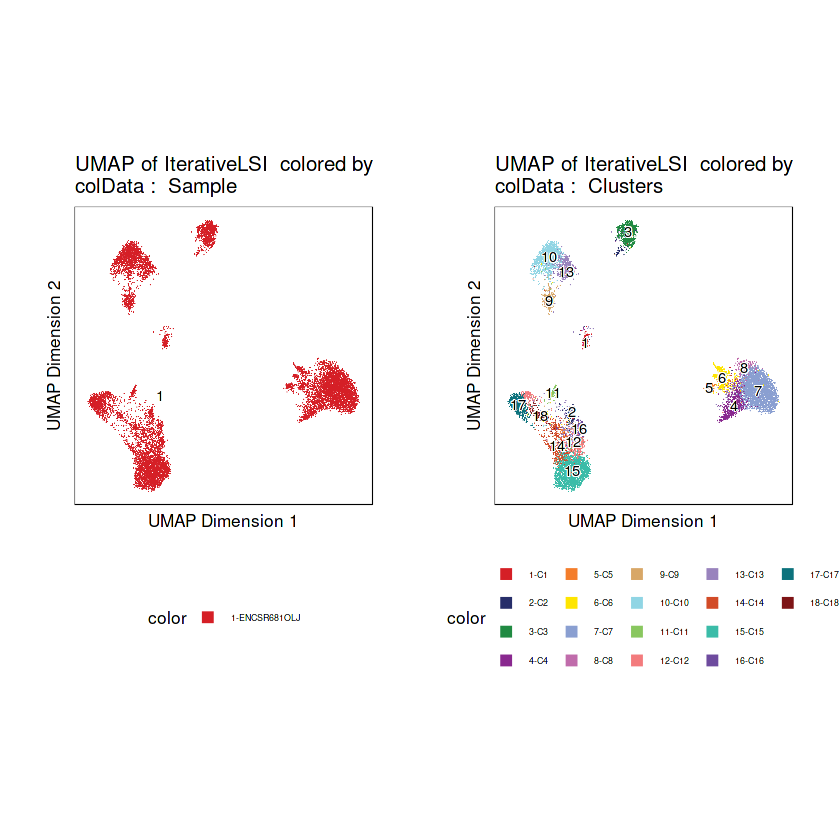

In [31]:
p1 <- plotEmbedding(ArchRProj = proj_ENCSR681OLJ, colorBy = "cellColData", name = "Sample", embedding = "UMAP")
p2 <- plotEmbedding(ArchRProj = proj_ENCSR681OLJ, colorBy = "cellColData", name = "Clusters", embedding = "UMAP")
ggAlignPlots(p1, p2, type = "h")
plotPDF(p1,p2, name = "Plot-UMAP-Sample-Clusters.pdf", ArchRProj = proj_ENCSR681OLJ, addDOC = FALSE, width = 5, height = 5)

In [32]:
# Checkpoint! Save the ArchR project for easy loading next time
saveArchRProject(ArchRProj = proj_ENCSR681OLJ, outputDirectory = paste0(OUT_DIR, "/ArchROut_ENCSR681OLJ"), load = FALSE)

Saving ArchRProject...



In [33]:
# Identify marker features to differentiate between clusters
markersGS <- getMarkerFeatures(
    ArchRProj = proj_ENCSR681OLJ, 
    useMatrix = "GeneScoreMatrix", 
    groupBy = "Clusters",
    bias = c("TSSEnrichment", "log10(nFrags)"),
    testMethod = "wilcoxon"
)

ArchR logging to : ArchRLogs/ArchR-getMarkerFeatures-33df996aabfcbe-Date-2024-05-07_Time-19-59-20.800017.log
If there is an issue, please report to github with logFile!

MatrixClass = Sparse.Double.Matrix

2024-05-07 19:59:20.99704 : Matching Known Biases, 0.002 mins elapsed.

###########
2024-05-07 20:00:32.515197 : Completed Pairwise Tests, 1.194 mins elapsed.
###########

ArchR logging successful to : ArchRLogs/ArchR-getMarkerFeatures-33df996aabfcbe-Date-2024-05-07_Time-19-59-20.800017.log



In [34]:
# Get markers
markerList <- getMarkers(markersGS, cutOff = "FDR <= 0.01 & Log2FC >= 1.25")

In [35]:
sum(which(genes_df[genes_df$symbol %in% markerList$C14$name,]$gene_type == "lncRNA"))

[1] 320

In [36]:
# Checkpoint! Save the ArchR project for easy loading next time
saveArchRProject(ArchRProj = proj_ENCSR681OLJ, outputDirectory = paste0(OUT_DIR, "/ArchROut_ENCSR681OLJ"), load = FALSE)

Saving ArchRProject...



In [37]:
# Set known marker genes
markerGenes  <- c(
    # Fibroblast
    "DCN", "LUM", "PODN",
    # Macrophages
    "C1QB", "CD163", "MS4A7",
    # Endothelial
    "EGFL7", "CLDN5", "VWF",
    # Smooth muscle cells
    "GJA4", "FOXL1", "CARMN",
    # Vascular smooth muscle cells
    "FOXC2", "MYLK",
    # T lymphocytes
    "IFNG", "CD3D", "GZMA",
    # Schwann cells
    "S100B", "SOX10", "PLP1",
    # B lymphocytes
    "IGHJ6", "IGHA1", "IGHA2",
    # Mast cells
    "GATA1", "MRGPRX2", "HDC",
    # Mesothelial cells
    "HAS1", "WT1",
    # Adipocytes
    "ADIPOQ", "CIDEC", "LEP", "SLC36A2", "P2RX5", "UCP1", "CIDEA", "PRDM16", "LHX8", "EPSTI1", "MC2R", "FFAR2", "PIKFYVE", "CYP11B2",
    "TLR2", "TLR4", "ADRB1", "ADRB2", "ADRB3", "FABP4", "TNFRSF9", "TBX1", "TMEM26", "TCF21", "ADIPOQ", "CFD", "ACVR1C", "SLC2A4",
    "LPIN1", "PLIN1", "PCK1", "PPARG", "RETN", "MEST", "ADM2", "STAT6", "TFE3", "CPPED1", "SLC1A5", "ACSL1", "CAR3", "CAVIN1", "AGT",
    "BCAT2", "PNPLA2", "CIDEC", "CDO1", "APOC1", "MMP2", "POSTN", "LOX", "COL6A2", "ZBTB16", "GULP1", "FZD4", "TRIP10", "FGF7", "MAOB",
    "SOCS1", "NNMT", "AOC3", "H6PD", "CYP27A1", "EBF2", "MNDA", "HSD11B1", "AR", "GDF10", "CYP1B1", "STEAP4", "CCL11", "DEPTOR", "TUSC5",
    "FMO1", "ACADSB", "XDH", "PTGES", "CREB3L1", "ANGPTL2", "ADH1", "LBP", "NMB", "RARRES2", "EGFR", "CPXM1", "C3", "ADAMTS5", "MT2A",
    "METRN", "METRNL", "MYO1C", "NQO1", "AQP5", "TSPO", "AZGP1", "LRP1", "PDE3B", "LGALS12", "SERPINF1", "CPT1B", "ELOVL3", "PPARGC1A", 
    "MPZL1", "CITED1", "DPT", "HOXC9", "ZNF423", "ESM1",
    # Cardiomyocytes
    "TNNT2", "NKX2-5", "NPPA", "TNNC1", "ADM2", "ALCAM", "NPPA", "FGF2", "NPPB", "TNNI3", "TNNT2", "ANKRD1", "NPPC", "DES", "HAND2", "HAND1",
    "GATA4", "GATA6", "MYL2", "PNMT", "ACTA1", "CD36", "VLDLR", "ALPK3", "RBM24", "FABP4", "CKMT2", "MYH7B", "MYOM2", "PDLIM5", "MYH7", "PLN",
    "TCAP", "SORBS2", "RYR2", "ACTC1", "MYL3", "PDE3D", "NEXN", "FHL2", "MYBPC3", "MYH6", "TTN", "GPIHBP1", "AQP1", "DMD", "MFN2", "ASB2", "ART3",
    "RRAD", "JPH2", "HSPB7", "MYOZ2", "ENO3", "TRDN", "ACTN2", "TNNI1", "SMPX", "MYL7", "TBX20", "TRIM63", "MB", "CTGF", "MYL4", "LOX", "CTNNB1",
    "CPT1A", "SOX18", "NOTCH1", "SLN", "CSRP3", "TXLNB", "ATP2A2", "CKMT2", "CKB", "CXCR4", "IL11RA", "MITF", "ZFPM2", "BDNF", "GJA5", "FMOD",
    "MTTP", "SLC5A1", "ADIPOQ", "TRPV1", "HAMP", "SGPL1", "HMGB2", "STC1", "FGF23", "STRN", "HEY2", "ADIPOR1", "ADIPOR2", "PDE1A", "BMP4", "CASQ2", "TMP1",
    # Adipocytes progenitor cells
    "FGF10", "WT1", "SCARA5", "HOXC8", "TCF7L1", "HOXC9", "EBF2", "NRG4",
    # Cardiac stem and precursor cells
    "NKX2-5", "ISL1", "MESP1", "ADGRL2", "TBX3", "TBX4", "WNT5A", "ANKRD1"
    
    
    
  )
markerGenes = unique(markerGenes)
markerGenes_geneIDs = genes_df[genes_df$gene_name %in% markerGenes,]$symbol
markerGenes_geneIDs = markerGenes_geneIDs[!grepl("PAR_Y", markerGenes_geneIDs)]

ArchR logging to : ArchRLogs/ArchR-plotMarkerHeatmap-33df997465367c-Date-2024-05-07_Time-20-00-40.140506.log
If there is an issue, please report to github with logFile!

Printing Top Marker Genes:

C1:

	ENSG00000171608.17, ENSG00000231789.3, ENSG00000020633.19, ENSG00000278034.1, ENSG00000154451.15, ENSG00000162676.13, ENSG00000116824.5, ENSG00000274020.4, ENSG00000227722.2, ENSG00000117560.8, ENSG00000229785.1, ENSG00000227240.2, ENSG00000237213.2, ENSG00000170128.5, ENSG00000143851.16

C2:

	ENSG00000226822.4, ENSG00000135678.12, ENSG00000230148.8, ENSG00000173917.11, ENSG00000178726.7, ENSG00000206531.11, ENSG00000222869.1, ENSG00000213744.3, ENSG00000241431.1, ENSG00000136869.16, ENSG00000205542.11, ENSG00000280222.1, ENSG00000289692.1, ENSG00000159189.13, ENSG00000173369.18

C3:

	ENSG00000283611.2, ENSG00000285604.1, ENSG00000222952.1, ENSG00000142634.13, ENSG00000157191.20, ENSG00000117115.13, ENSG00000282843.1, ENSG00000142623.11, ENSG00000117154.12, ENSG00000230035.2, ENSG000

  [1] "ENSG00000142611.17" "ENSG00000049249.9"  "ENSG00000049239.13"
  [4] "ENSG00000175206.11" "ENSG00000120937.9"  "ENSG00000116688.18"
  [7] "ENSG00000173641.18" "ENSG00000173369.18" "ENSG00000158022.7" 
 [10] "ENSG00000187513.9"  "ENSG00000174348.14" "ENSG00000162624.16"
 [13] "ENSG00000162614.19" "ENSG00000117114.21" "ENSG00000118729.12"
 [16] "ENSG00000265107.3"  "ENSG00000163563.8"  "ENSG00000197965.12"
 [19] "ENSG00000143196.5"  "ENSG00000010932.17" "ENSG00000118194.21"
 [22] "ENSG00000159173.19" "ENSG00000159346.13" "ENSG00000122176.12"
 [25] "ENSG00000117594.10" "ENSG00000143632.15" "ENSG00000135744.9" 
 [28] "ENSG00000077522.15" "ENSG00000198626.18" "ENSG00000266524.3" 
 [31] "ENSG00000196932.12" "ENSG00000166224.17" "ENSG00000148677.7" 
 [34] "ENSG00000119915.5"  "ENSG00000043591.6"  "ENSG00000196177.13"
 [37] "ENSG00000177666.17" "ENSG00000152270.9"  "ENSG00000183695.3" 
 [40] "ENSG00000129170.10" "ENSG00000176697.20" "ENSG00000184937.16"
 [43] "ENSG00000157613.11" "ENSG00

Adding Annotations..

Preparing Main Heatmap..

'magick' package is suggested to install to give better rasterization.

Set `ht_opt$message = FALSE` to turn off this message.

ArchR logging successful to : ArchRLogs/ArchR-plotMarkerHeatmap-33df997465367c-Date-2024-05-07_Time-20-00-40.140506.log

Plotting ComplexHeatmap!



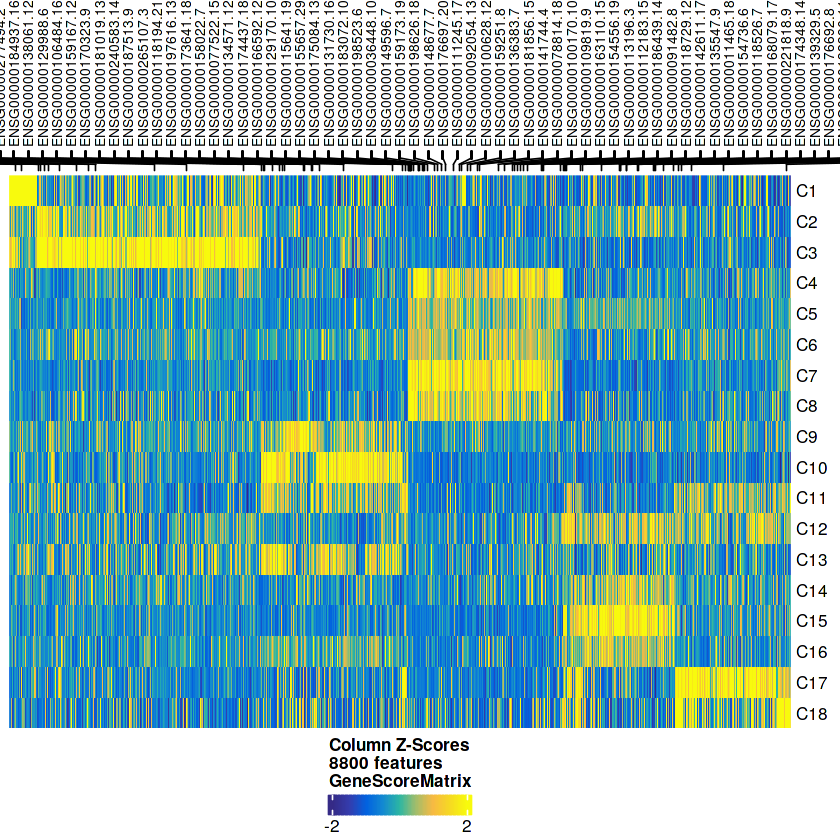

In [38]:
# Plot a heatmap of marker genes
heatmapGS <- plotMarkerHeatmap(
  seMarker = markersGS, 
  cutOff = "FDR <= 0.01 & Log2FC >= 1.25", 
  labelMarkers = markerGenes_geneIDs,
  transpose = TRUE
)
ComplexHeatmap::draw(heatmapGS, heatmap_legend_side = "bot", annotation_legend_side = "bot")
plotPDF(heatmapGS, name = "GeneScores-Marker-Heatmap", width = 8, height = 6, ArchRProj = proj_ENCSR681OLJ, addDOC = FALSE)

In [39]:
# Impute weights with MAGIC
proj_ENCSR681OLJ <- addImputeWeights(proj_ENCSR681OLJ)

ArchR logging to : ArchRLogs/ArchR-addImputeWeights-33df99385f0957-Date-2024-05-07_Time-20-00-52.033083.log
If there is an issue, please report to github with logFile!

2024-05-07 20:00:52.103922 : Computing Impute Weights Using Magic (Cell 2018), 0 mins elapsed.



Getting ImputeWeights

ArchR logging to : ArchRLogs/ArchR-plotEmbedding-33df997d04c17b-Date-2024-05-07_Time-20-01-04.801241.log
If there is an issue, please report to github with logFile!

Getting UMAP Embedding

ColorBy = GeneScoreMatrix

Getting Matrix Values...

2024-05-07 20:01:04.987437 : 

1 


Imputing Matrix

Using weights on disk

Using weights on disk

Plotting Embedding

1 
2 
3 
4 
5 
6 
7 
8 
9 
10 
11 
12 
13 
14 
15 
16 
17 
18 
19 
20 
21 
22 
23 
24 
25 
26 
27 
28 
29 
30 
31 
32 
33 
34 
35 
36 
37 
38 
39 
40 
41 
42 
43 
44 
45 
46 
47 
48 
49 
50 
51 
52 
53 
54 
55 
56 
57 
58 
59 
60 
61 
62 
63 
64 
65 
66 
67 
68 
69 
70 
71 
72 
73 
74 
75 
76 
77 
78 
79 
80 
81 
82 
83 
84 
85 
86 
87 
88 
89 
90 
91 
92 
93 
94 
95 
96 
97 
98 
99 
100 
101 
102 
103 
104 
105 
106 
107 
108 
109 
110 
111 
112 
113 
114 
115 
116 
117 
118 
119 
120 
121 
122 
123 
124 
125 
126 
127 
128 
129 
130 
131 
132 
133 
134 
135 
136 
137 
138 
139 
140 
141 
142 
143 
144 
145

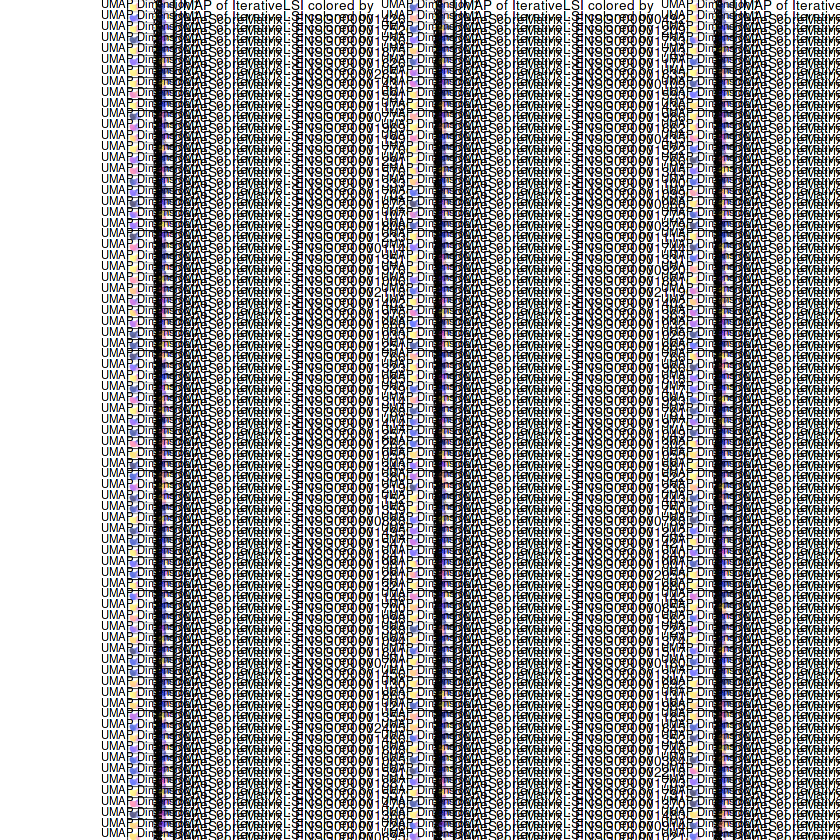

In [40]:
# Overlay marker gene expression on the embedding
p <- plotEmbedding(
    ArchRProj = proj_ENCSR681OLJ, 
    colorBy = "GeneScoreMatrix", 
    name = markerGenes_geneIDs, 
    embedding = "UMAP",
    imputeWeights = getImputeWeights(proj_ENCSR681OLJ)
)
#Rearrange for grid plotting
p2 <- lapply(p, function(x){
    x + guides(color = FALSE, fill = FALSE) + 
    theme_ArchR(baseSize = 6.5) +
    theme(plot.margin = unit(c(0, 0, 0, 0), "cm")) +
    theme(
        axis.text.x=element_blank(), 
        axis.ticks.x=element_blank(), 
        axis.text.y=element_blank(), 
        axis.ticks.y=element_blank()
    )
})
do.call(cowplot::plot_grid, c(list(ncol = 3),p2))
plotPDF(plotList = p, 
    name = "Plot-UMAP-Marker-Genes-W-Imputation.pdf", 
    ArchRProj = proj_ENCSR681OLJ, 
    addDOC = FALSE, width = 5, height = 5)

In [41]:
# Checkpoint! Save the ArchR project for easy loading next time
saveArchRProject(ArchRProj = proj_ENCSR681OLJ, outputDirectory = paste0(OUT_DIR, "/ArchROut_ENCSR681OLJ"), load = FALSE)

Saving ArchRProject...



In [42]:
p <- plotBrowserTrack(
    ArchRProj = proj_ENCSR681OLJ, 
    groupBy = "Clusters", 
    geneSymbol = markerGenes_geneIDs, 
    upstream = 50000,
    downstream = 50000
)

ArchR logging to : ArchRLogs/ArchR-plotBrowserTrack-33df993498f418-Date-2024-05-07_Time-20-07-13.53153.log
If there is an issue, please report to github with logFile!

2024-05-07 20:07:13.598067 : Validating Region, 0.001 mins elapsed.



GRanges object with 231 ranges and 8 metadata columns:
        seqnames              ranges strand |     filler1     filler2
           <Rle>           <IRanges>  <Rle> | <character> <character>
    [1]     chr1     3069167-3438621      + |           .           .
    [2]     chr1     7915870-7943165      - |           .           .
    [3]     chr1     9234773-9271337      + |           .           .
    [4]     chr1   11845708-11848345      - |           .           .
    [5]     chr1   11857463-11858945      - |           .           .
    ...      ...                 ...    ... .         ...         ...
  [227]     chrX   48786539-48794311      + |           .           .
  [228]     chrX   49028725-49043410      - |           .           .
  [229]     chrX   67544020-67730619      + |           .           .
  [230]     chrX   72301637-72307187      - |           .           .
  [231]     chrX 103773717-103792619      + |           .           .
                    symbol   gene_n

2024-05-07 20:07:13.821531 : Adding Bulk Tracks (1 of 231), 0.005 mins elapsed.

Getting Region From Arrow Files 1 of 1

2024-05-07 20:07:17.836992 : Adding Gene Tracks (1 of 231), 0.072 mins elapsed.

2024-05-07 20:07:18.178216 : Plotting, 0.077 mins elapsed.

2024-05-07 20:07:20.017584 : Adding Bulk Tracks (2 of 231), 0.108 mins elapsed.

Getting Region From Arrow Files 1 of 1

2024-05-07 20:07:21.53706 : Adding Gene Tracks (2 of 231), 0.133 mins elapsed.

2024-05-07 20:07:21.888925 : Plotting, 0.139 mins elapsed.

2024-05-07 20:07:23.696183 : Adding Bulk Tracks (3 of 231), 0.169 mins elapsed.

Getting Region From Arrow Files 1 of 1

2024-05-07 20:07:25.19496 : Adding Gene Tracks (3 of 231), 0.194 mins elapsed.

2024-05-07 20:07:25.453558 : Plotting, 0.199 mins elapsed.

2024-05-07 20:07:27.501151 : Adding Bulk Tracks (4 of 231), 0.233 mins elapsed.

Getting Region From Arrow Files 1 of 1

2024-05-07 20:07:30.484618 : Adding Gene Tracks (4 of 231), 0.283 mins elapsed.

2024-05-07 20:

In [43]:
# Checkpoint! Save the ArchR project for easy loading next time
saveArchRProject(ArchRProj = proj_ENCSR681OLJ, outputDirectory = paste0(OUT_DIR, "/ArchROut_ENCSR681OLJ"), load = FALSE)

Saving ArchRProject...

